In [1]:
import sys
sys.path.append('../')
import trimesh
import networkx as nx
from models.gan_model import *

from tqdm import tqdm
from torch.utils.data import Dataset
from pathlib import Path

In [2]:
class STLDataset(Dataset):
    def __init__(self, root_path, tensor_size):
        self.stl_path = root_path
        self.stl_list = sorted(self._get_filenames(self.stl_path))
        self.tensor_size = tensor_size

    def __getitem__(self, idx):
        mesh = trimesh.load_mesh(self.stl_list[idx])
        try:
            adj = torch.from_numpy(
                nx.adjacency_matrix(trimesh.graph.vertex_adjacency_graph(mesh)
                                  ).toarray()).float()
            
            vertices_coords = self.fix_size_coords(torch.from_numpy(mesh.vertices), tensor_size=self.tensor_size)
            adj = self.fix_size_adj(adj, tensor_size=self.tensor_size)
            return adj, vertices_coords
        except:
            print(self.stl_list[idx])

    def __len__(self):
        return len(self.stl_list)

    @staticmethod
    def _get_filenames(path):
        return [f for f in path.iterdir() if f.is_file()]

    @staticmethod
    def fix_size_adj(input_tensor, tensor_size):
        if input_tensor.shape[0] < tensor_size:
            zeros = torch.zeros(input_tensor.shape[0], tensor_size - input_tensor.shape[0])
            tensor = torch.cat([input_tensor, zeros], dim=1)

            zeros = torch.zeros(tensor_size - input_tensor.shape[0], tensor_size)
            tensor = torch.cat([tensor, zeros], dim=0)
            return tensor
        elif input_tensor.shape[0] > tensor_size:
            return input_tensor[:tensor_size, :tensor_size]
        else:
            return input_tensor

    @staticmethod
    def fix_size_coords(input_tensor, tensor_size):
        if input_tensor.shape[0] < tensor_size:
            zeros = torch.zeros(tensor_size - input_tensor.shape[0], input_tensor.shape[1])
            tensor = torch.cat([input_tensor, zeros], dim=0)

            return tensor
        elif input_tensor.shape[0] > tensor_size:
            return input_tensor[:tensor_size]
        else:
            return input_tensor

In [3]:
input_dir = "../data/Thingi10K/models"
NUM_VERTEX = 60

dataset = STLDataset(Path(input_dir), tensor_size=NUM_VERTEX)

In [4]:
batch_size = 512
z_size = 100
data_loader = torch.utils.data.DataLoader(
    dataset, batch_size=batch_size, shuffle=True
)

In [5]:
device = 'cuda'
adj_gan = GraphGAN(num_vertex=NUM_VERTEX, lr=1e-4, device=device)

In [6]:
def train(model, dataloader, num_epochs=10):
    bar = tqdm(range(num_epochs))
    for epoch in bar:
        g_l = 0
        d_l = 0
        for batch in dataloader:
            adj, _ = batch
            image_size = adj.size(0)

            gl, dl = model.forward(adj.to(device), image_size)
            g_l += gl
            d_l += dl
        bar.set_postfix_str(f"Epoch: {epoch + 1}/{num_epochs}\td_loss: {d_l / len(dataloader)}\tg_loss: {g_l / len(dataloader)}")

In [7]:
train(adj_gan, data_loader, num_epochs=100)

100%|██████████| 100/100 [1:35:53<00:00, 57.53s/it, Epoch: 100/100	d_loss: 0.9326284130414327	g_loss: 2.174004832903544]


In [8]:
graph_output = adj_gan.generate_adj(return_symmetric=True)
graph_output = graph_output.cpu().detach().numpy()

In [9]:
G = nx.from_numpy_array(graph_output, create_using=nx.Graph())

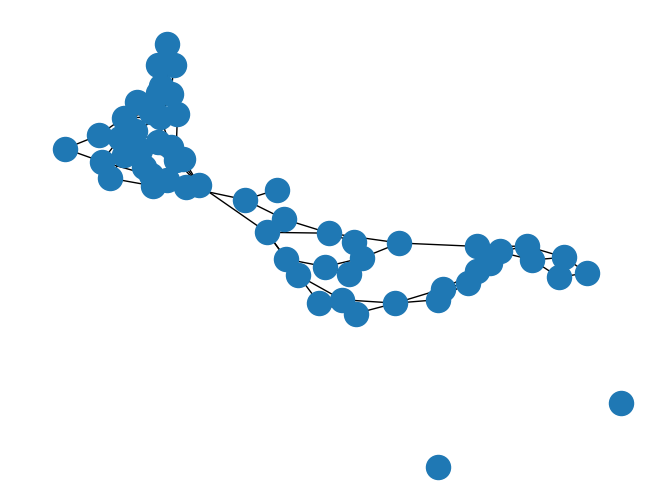

In [10]:
nx.draw(G)

In [11]:
torch.save(adj_gan.state_dict(), '../models/weigths/adj_gan_100_60')